#Universitario: Ceron Beimar Miguel
#Carrera: Ingenieria de Sistemas


In [ ]:
# Repositorio GITHub:
# https://github.com/sergiombdev/sis420-ing.sistemas-S.M.B/tree/master/laboratorios/laboratorio09

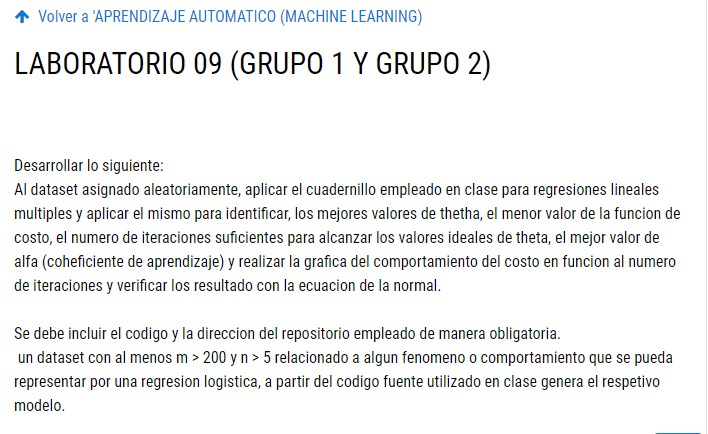

# Ejercicio de programación Regresión Lineal Multiple

In [28]:
# utilizado para manejos de directorios y rutas
import os

# Computacion vectorial y cientifica para python
import numpy as np

# Librerias para graficación (trazado de gráficos)
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # Necesario para graficar superficies 3D

# llama a matplotlib a embeber graficas dentro de los cuadernillos
%matplotlib inline

## 2 Regresión lineal con multiples variables

Se implementa la regresion lineal multivariable para predecir el precio de las casas. El archivo `Datasets/ex1data2.txt` contiene un conjunto de entrenamiento de precios de casas en Portland, Oregon. La primera columna es el tamaño de la casa en metros cuadrados, la segunda columna es el numero de cuartos, y la tercera columna es el precio de la casa. 

<a id="section4"></a>
### 2.1 Normalización de caracteristicas

Al visualizar los datos se puede observar que las caracteristicas tienen diferentes magnitudes, por lo cual se debe transformar cada valor en una escala de valores similares, esto con el fin de que el descenso por el gradiente pueda converger mas rapidamente.

In [ ]:
# Valores Columna de X : region,	year,	is_new,	manufacturer,	meter_hours,	category
# Valores Columna de Y : price_usd

In [29]:
# Cargar datos
data = np.loadtxt( os.path.join("data0.csv"), skiprows=1, delimiter = ',')

X = data[:, :6]
y = data[:, 6]
m = y.size

La desviación estándar es una forma de medir cuánta variación hay en el rango de valores de una característica en particular (la mayoría de los puntos caeran en un rango de ± 2 en relación a la desviaciones estándar de la media); esta es una alternativa a tomar el rango de valores (max-min). En `numpy`, se puede usar la función `std` para calcular la desviacion estandar. 

Por ejemplo, la caracteristica`X[:, 0]` contiene todos los valores de $x_1$ (tamaño de las casas) en el conjunto de entrenamiento, entonces `np.std(X[:, 0])` calcula la desviacion estandar de los tamaños de las casas.
En el momento en que se llama a la función `featureNormalize`, la columna adicional de unos correspondiente a $ x_0 = 1 $ aún no se ha agregado a $ X $. 

<div class="alert alert-block alert-warning">
**Notas para la implementación:** Cuando se normalize una caracteristica, es importante almacenar los valores usados para la normalización - el valor de la media y el valor de la desviación estandar usado para los calculos. Despues de aprender los parametros del modelo, se deseara predecir los precios de casas que no se han visto antes. Dado un nuevo valor de x (area del living room y el numero de dormitorios), primero se debe normalizar x usando la media y la desviacion estandar que se empleo anteriormente en el conjunto de entrenamiento para entrenar el modelo.
</div>
<a id="featureNormalize"></a>

In [3]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma

In [30]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

print(X)
print('Media calculada:', mu)
print('Desviación estandar calculada:', sigma)
print(X_norm)

[[  71. 2010.    0.  108.  461.  111.]
 [  33. 2002.    0.   30.    0.   56.]
 [  39. 2011.    0.   95.  277.   90.]
 ...
 [  40. 2019.    0.   30.  415.   24.]
 [  74. 2019.    0.   30.  296.   24.]
 [  35. 2016.    0.   76. 1613.   30.]]
Media calculada: [3.99046525e+01 2.01266341e+03 3.96323952e-02 6.52768524e+01
 3.11263469e+03 6.92130959e+01]
Desviación estandar calculada: [2.38428727e+01 5.14637883e+00 1.95093999e-01 5.13800503e+01
 2.12477586e+04 3.69289174e+01]
[[ 1.30417789 -0.51753124 -0.20314513  0.83151237 -0.12479597  1.13154966]
 [-0.28958979 -2.07202233 -0.20314513 -0.68658657 -0.14649238 -0.35779808]
 [-0.03794226 -0.32321986 -0.20314513  0.57849588 -0.13345571  0.56288961]
 ...
 [ 0.00399899  1.23127123 -0.20314513 -0.68658657 -0.12696091 -1.22432768]
 [ 1.43000166  1.23127123 -0.20314513 -0.68658657 -0.1325615  -1.22432768]
 [-0.20570728  0.64833707 -0.20314513  0.20870255 -0.07057849 -1.06185338]]


Despues de `featureNormalize` la funcion es provada, se añade el temino de interseccion a `X_norm`:

In [31]:
# Añade el termino de interseccion a X
# (Columna de unos para X0)
X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

In [32]:
print(X)

[[ 1.          1.30417789 -0.51753124 ...  0.83151237 -0.12479597
   1.13154966]
 [ 1.         -0.28958979 -2.07202233 ... -0.68658657 -0.14649238
  -0.35779808]
 [ 1.         -0.03794226 -0.32321986 ...  0.57849588 -0.13345571
   0.56288961]
 ...
 [ 1.          0.00399899  1.23127123 ... -0.68658657 -0.12696091
  -1.22432768]
 [ 1.          1.43000166  1.23127123 ... -0.68658657 -0.1325615
  -1.22432768]
 [ 1.         -0.20570728  0.64833707 ...  0.20870255 -0.07057849
  -1.06185338]]


<a id="section5"></a>
### 2.2 Descenso por el gradiente

En el ejemplo anterior se implemento el descenso por el gradiente para un problema de regresion univariable. La unica diferencia es que ahora existe una caracteristica adicional en la matriz $X$. La función de hipótesis y la regla de actualización del descenso del gradiente por lotes permanecen sin cambios.

La implementacion de las funciones `computeCostMulti` y `gradientDescentMulti` son similares a la funcion de costo y función de descenso por el gradiente de la regresión lineal multiple es similar al de la regresion lineal multivariable. Es importante garantizar que el codigo soporte cualquier numero de caracteristicas y esten bien vectorizadas.

Se puede utilizar `shape`, propiedad de los arrays `numpy`, para identificar cuantas caracteristicas estan consideradas en el dataset.

<div class="alert alert-block alert-warning">
**Nota de implementación:** En el caso de multivariables, la función de costo puede se escrita considerando la forma vectorizada de la siguiente manera:

$$ J(\theta) = \frac{1}{2m}(X\theta - \vec{y})^T(X\theta - \vec{y}) $$

donde:

$$ X = \begin{pmatrix}
          - (x^{(1)})^T - \\
          - (x^{(2)})^T - \\
          \vdots \\
          - (x^{(m)})^T - \\ \\
        \end{pmatrix} \qquad \mathbf{y} = \begin{bmatrix} y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)} \\\end{bmatrix}$$

La version vectorizada es eficiente cuando se trabaja con herramientas de calculo numericos computacional como `numpy`. 
</div>

<a id="computeCostMulti"></a>

In [33]:
def computeCostMulti(X, y, theta):
    # Inicializa algunos valores utiles
    m = y.shape[0] # numero de ejemplos de entrenamiento
    
    J = 0
    
    h = np.dot(X, theta)
    
    J = (1/(2 * m)) * np.sum(np.square(np.dot(X, theta) - y))
    
    return J


In [34]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):
    
    # Inicializa algunos valores 
    m = y.shape[0] # numero de ejemplos de entrenamiento
    
    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()
    
    J_history = []
    
    for i in range(num_iters):
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        J_history.append(computeCostMulti(X, y, theta))
    
    return theta, J_history

#### 3.2.1 Seleccionando coheficientes de aprendizaje


costo min calculado : 4214499229.5071216
theta calculado por el descenso por el gradiente: [94178.6308345    122.83456123 -1436.2143825   2541.69227991
 -2464.95343761 -1752.90392507  -315.95668607]


El precio : 96435.2015368016 USD.
El precio : 96435.2015368016 USD.


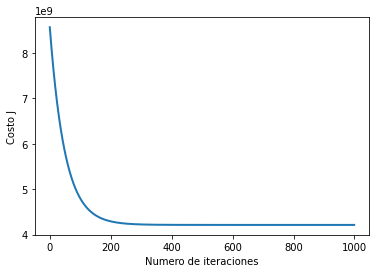

In [35]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.01
num_iters = 1000

# alpha = 0.001
# num_iters = 30000

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(7)
theta, J_history = gradientDescentMulti(X, y, theta, alpha, num_iters)

# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

print("costo min calculado : "+str(J_history[-1]))

# Muestra los resultados del descenso por el gradiente
print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))


X_array = [1.0,38,1998,0,96,0,80]
X_array[1:7] = (X_array[1:7] - mu) / sigma
result = np.dot(X_array, theta)

print("\n")
print("El precio : "+ str( result ) + " USD.")

X_array2 = [1.0,38,1998,0,96,0,80]
X_array2[1:7] = (X_array2[1:7] - mu) / sigma
result2 = np.dot(X_array2, theta)

print("El precio : "+ str( result2 ) + " USD.")
# 1774.401179747277
# 777.200316957715

In [36]:
X_array = [1.0, 64,2019,0,30,566,24]
X_array[1:7] = (X_array[1:7] - mu) / sigma

In [37]:
X_array[1:7]

[1.0105891084596959,
 1.2312712264587158,
 -0.2031451269012669,
 -0.6865865678622074,
 -0.11985427436844864,
 -1.2243276841671495]

<a id="section7"></a>
### 2.3 Ecuacion de la Normal

Una manera de calcular rapidamente el modelo de una regresion lineal es:

$$ \theta = \left( X^T X\right)^{-1} X^T\vec{y}$$

Utilizando esta formula no requiere que se escale ninguna caracteristica, y se obtendra una solucion exacta con un solo calculo: no hay “bucles de convergencia” como en el descenso por el gradiente. 

Primero se recargan los datos para garantizar que las variables no esten modificadas. Recordar que no es necesario escalar las caracteristicas, se debe agregar la columna de unos a la matriz $X$ para tener el termino de intersección($\theta_0$). 

In [38]:
# Cargar datos
data = np.loadtxt( os.path.join("data0.csv"), skiprows=1, delimiter = ',')

X = data[:, :6]
y = data[:, 6]
m = y.size
X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [40]:
def normalEqn(X, y):
  
    theta = np.zeros(X.shape[1])
    
    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)
    
    return theta

In [41]:
# Calcula los parametros con la ecuación de la normal
theta = normalEqn(X, y);

# Muestra los resultados optenidos a partir de la aplicación de la ecuación de la normal
print('Theta calculado a partir de la ecuación de la normal: {:s}'.format(str(theta)));


# Estimar el precio para una casa de superficie de 1650 sq-ft y tres dormitorios

X_array = [1.0,38,1998,0,96,0,80]
result = np.dot(X_array, theta) 
print("El precio : "+ str( result ) + " USD.")

X_array2 = [1.0,64,2019,0,30,566,24]
result2 = np.dot(X_array2, theta) 
print("El precio : "+ str( result2 ) + " USD.")


Theta calculado a partir de la ecuación de la normal: [ 6.59752663e+05  5.13443450e+00 -2.79385441e+02  1.30373502e+04
 -4.79914034e+01 -8.24955299e-02 -8.57056866e+00]
El precio : 96442.84143917795 USD.
El precio : 94309.93448592196 USD.
